In [17]:
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import librosa
import librosa.display
import numpy as np
import math
from tqdm import tqdm

In [18]:
def quantize_beats(beats, onset_env, tempo, sr, hop_length, duration):
    """
    Adjusts beat times to the nearest detected onsets and creates beat and measure grids for the audio.

    This function assumes the beat times are evenly spaced within each measure and are in 4/4 time signature. It also backtracks the beats using the onset envelope to align them to the nearest detected onset.

    Parameters:
    beats : np.ndarray
        An array of beat times in frame units generated from librosa.beat.beat_track.
    onset_env : np.ndarray
        Onset envelope of the audio signal, used for backtracking beats.
    tempo : float
        Estimated tempo of the audio in beats per minute.
    sr : int
        Sampling rate of the audio signal.
    hop_length : int
        Hop length used in the onset detection and beat tracking.
    duration : float
        Duration of the audio signal in seconds.

    Returns:
    beat_grid : np.ndarray
        Array of quantized beat times.
    measure_grid : np.ndarray
        Array of quantized measure start times.
    beats_per_measure : int
        Number of beats per measure, which is set to 4 for a 4/4 time signature.

    Raises:
    ValueError: If the `beats` array is empty or not one-dimensional.
    """
    # Validate input
    if beats.ndim != 1:
        raise ValueError("The 'beats' array must be one-dimensional.")
    if beats.size == 0:
        raise ValueError("The 'beats' array must not be empty.")
    
    # Hardcoded assumption of 4/4 time signature
    beats_per_measure = 4

    # Track beats to align them to the nearest detected onset
    beat_times = librosa.frames_to_time(beats, sr=sr, hop_length=hop_length)

    # Calculate the beat interval (seconds per beat)
    beat_interval = 60.0 / tempo

    # Backtrack from the first beat to align with time 0 if necessary
    first_beat_time = 0

    # Create beat grid from the first beat time to the end of the song
    beat_grid = np.arange(first_beat_time, duration, beat_interval)

    # Ensure beat grid does not go past the duration of the song
    beat_grid = beat_grid[beat_grid <= duration]

    # Create measure grid
    measure_indices = np.arange(0, len(beat_grid), beats_per_measure)
    measure_grid = beat_grid[measure_indices]

    # Ensure measure grid does not go past the duration of the song
    measure_grid = measure_grid[measure_grid <= duration]

    return beat_grid, measure_grid


def apply_measure_grid(ax, measure_grid, measure_numbers):
    """
    This function takes an axis object and applies measure grid lines,
    sets x-ticks to measure start times for every fourth measure starting from measure 0,
    labels them with measure numbers, and applies sub-ticks for intermediate measure times.
    
    Parameters:
    ax (matplotlib.axes.Axes): The axis object to modify.
    measure_grid (list or array): The list or array of measure start times in seconds.
    measure_numbers (list or array): The list or array of measure numbers corresponding to the start times.
    """
    # Adjust the list to start from measure 0 and get every fourth measure
    major_measure_indices = [i for i, measure_num in enumerate(measure_numbers) if (measure_num) % 4 == 0]
    major_measures = [measure_grid[i] for i in major_measure_indices]
    major_labels = [measure_numbers[i] for i in major_measure_indices]
    
    # Set major x-axis ticks and labels (for measure 0 and every fourth measure after)
    ax.set_xticks(major_measures, minor=False)
    ax.set_xticklabels(major_labels, minor=False)

    # Set minor x-axis ticks (for intermediate measures)
    minor_measures = [measure for i, measure in enumerate(measure_grid) if i not in major_measure_indices]
    ax.set_xticks(minor_measures, minor=True)
    
    # Overlay the major measure grid lines on the plot (for measure 0 and every fourth measure after)
    for measure_time in major_measures:
        ax.axvline(x=measure_time, color='green', linestyle='--', linewidth=2)  # Adjusted linewidth for major ticks
    
    # Overlay the minor measure grid lines on the plot (for intermediate measures)
    for measure_time in minor_measures:
        ax.axvline(x=measure_time, color='grey', linestyle=':', linewidth=1, alpha=0.8)  # Adjusted linewidth for minor ticks
    
    ax.set_xlabel('Measure Number')

In [12]:
export_directory = r"..\figures\audio_plots"

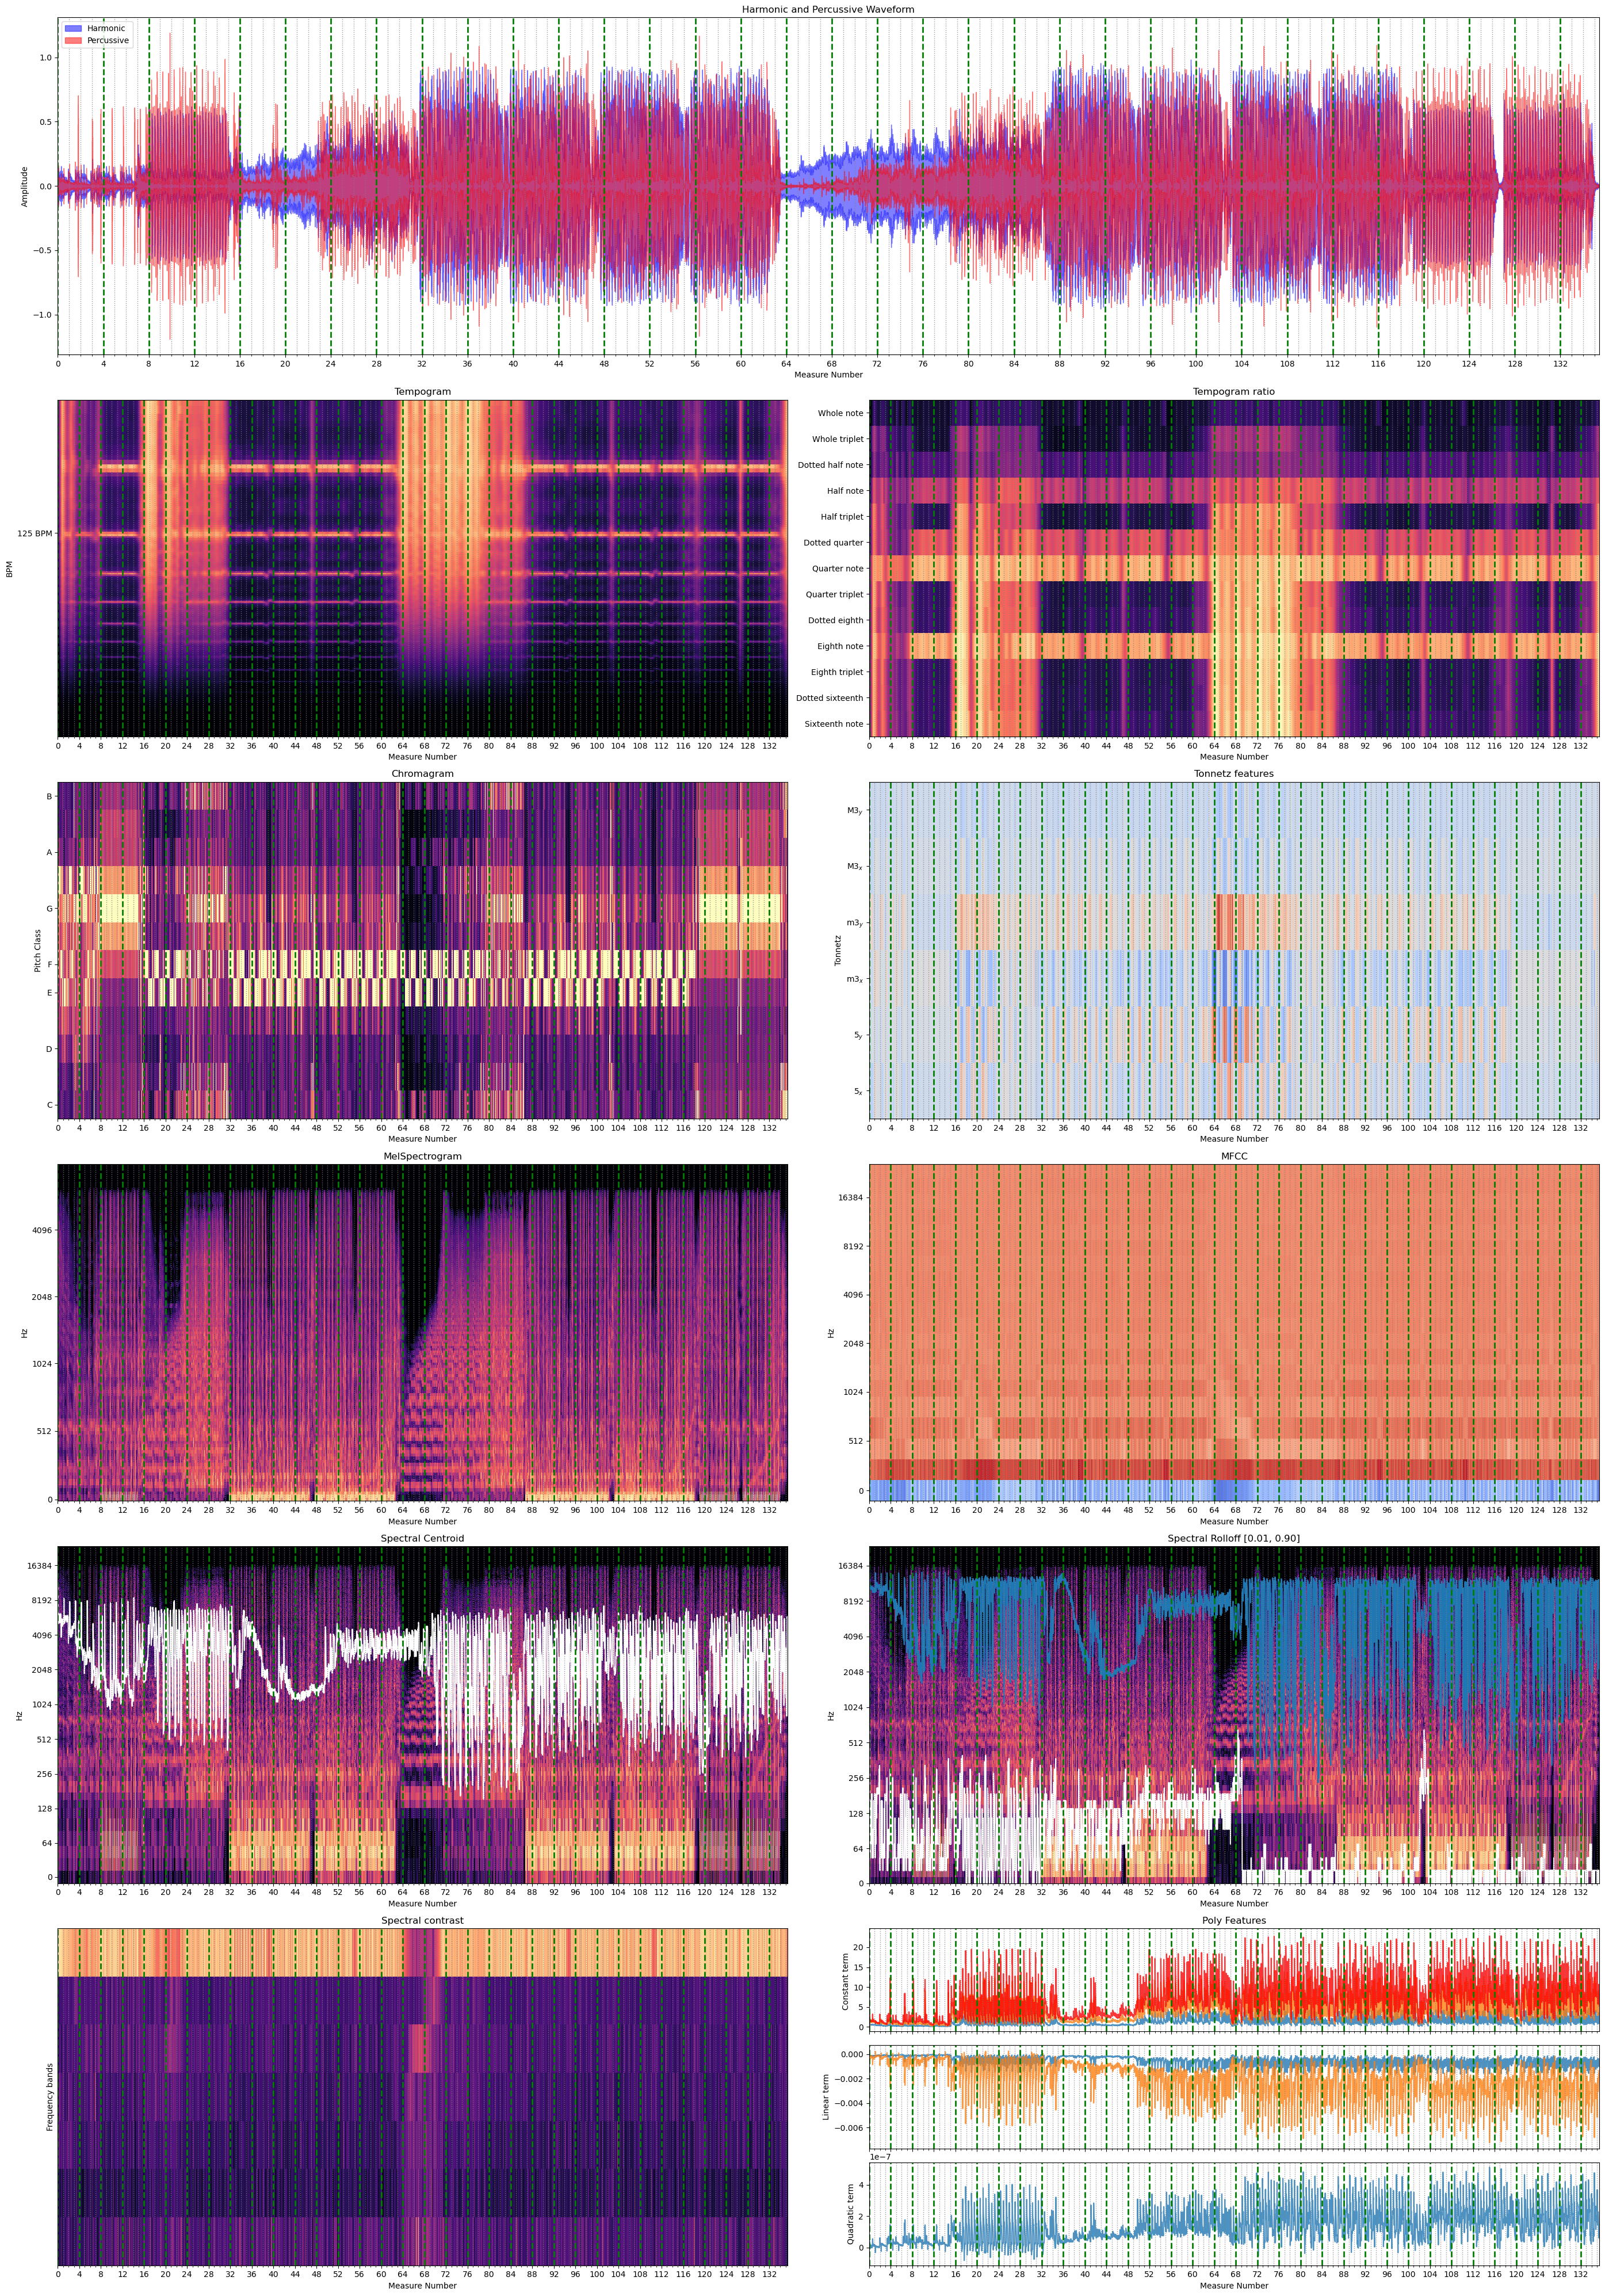

<Figure size 640x480 with 0 Axes>

In [15]:
audio_file = os.listdir(mp3_directory)[0]
mp3_directory = r'..\data\audio_files\processed'
song_id = os.path.splitext(audio_file)[0]
file_path = os.path.join(mp3_directory, audio_file)
# Load the audio file
y, sr = librosa.load(file_path, sr=None)
duration = librosa.get_duration(y=y, sr=sr)
hop_length = 512
y_harm, y_perc = librosa.effects.hpss(y)
onset_env = librosa.onset.onset_strength(y=y, sr=sr)
tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
tempo = math.floor(tempo)

# Quantize beats and create measure grid
beat_grid, measure_grid = quantize_beats(beats, onset_env, tempo, sr, hop_length, duration)
measure_numbers = np.arange(len(measure_grid))
measure_dict = {measure_number: measure_time for measure_number, measure_time in zip(measure_numbers, measure_grid)}

# Start a new figure
fig = plt.figure(figsize=(28, 40))  # Adjust the size as needed

# Create a GridSpec for the entire figure
gs = gridspec.GridSpec(6, 2, figure=fig)

# Harmonic/Percussive Waveform plot spanning 2 columns --------------------------------------------------------
ax_waveform = plt.subplot(gs[0, :])  # Spans first row and both columns
librosa.display.waveshow(y_harm, sr=sr, alpha=0.5, ax=ax_waveform, label='Harmonic', color = 'b')
librosa.display.waveshow(y_perc, sr=sr, alpha=0.5, ax=ax_waveform, label='Percussive', color='r')
ax_waveform.set_xlim([0, duration])   
apply_measure_grid(ax_waveform, measure_grid, measure_numbers)
ax_waveform.set_title('Harmonic and Percussive Waveform')
ax_waveform.set_ylabel('Amplitude')
ax_waveform.legend()

# Tempogram plot
ax_tempogram = plt.subplot(gs[1, 0])
tempogram = librosa.feature.tempogram(onset_envelope=onset_env, sr=sr, hop_length=hop_length)
librosa.display.specshow(tempogram, sr=sr, hop_length=hop_length, x_axis='time', y_axis='tempo', ax=ax_tempogram)
ax_tempogram.set_yticks([tempo])
ax_tempogram.set_yticklabels([str(tempo) + ' BPM'])
apply_measure_grid(ax_tempogram, measure_grid, measure_numbers)
ax_tempogram.set(title='Tempogram')

# Tempogram ratio
ax_tgr = plt.subplot(gs[1, 1])
tgr = librosa.feature.tempogram_ratio(tg=tempogram, sr=sr)
# Define note labels
note_labels = [
    'Sixteenth note',
    'Dotted sixteenth',
    'Eighth triplet',
    'Eighth note',
    'Dotted eighth',
    'Quarter triplet',
    'Quarter note',
    'Dotted quarter',
    'Half triplet',
    'Half note',
    'Dotted half note',
    'Whole triplet',
    'Whole note'
]
librosa.display.specshow(tgr, x_axis='time', ax=ax_tgr, sr=sr)
ax_tgr.set_xlim([0, duration])
apply_measure_grid(ax_tgr, measure_grid, measure_numbers)
ax_tgr.set(title="Tempogram ratio")
ax_tgr.set_yticks(range(len(note_labels)))
ax_tgr.set_yticklabels(note_labels)

# Chromagram plot
ax_chromagram = plt.subplot(gs[2, 0])
chroma_cq = librosa.feature.chroma_cqt(y=y, sr=sr)
librosa.display.specshow(chroma_cq, sr=sr, hop_length=hop_length, y_axis='chroma', x_axis='time', ax=ax_chromagram)
apply_measure_grid(ax_chromagram, measure_grid, measure_numbers)
ax_chromagram.set_ylabel('Pitch Class')
ax_chromagram.set_title('Chromagram')

# Tonnetz Features plot
ax_tonnetz = plt.subplot(gs[2, 1])
tonnetz = librosa.feature.tonnetz(y=y, sr=sr, chroma=chroma_cq)
librosa.display.specshow(tonnetz, sr=sr, hop_length=hop_length, y_axis='tonnetz', x_axis='time', ax=ax_tonnetz)
apply_measure_grid(ax_tonnetz, measure_grid, measure_numbers)
ax_tonnetz.set_title('Tonnetz features')

# MelSpectrogram plot
ax_melspec = plt.subplot(gs[3, 0])
# Compute Melspectrogram
D = np.abs(librosa.stft(y))**2
S = librosa.feature.melspectrogram(S=D, sr=sr)
S_dB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax_melspec)
apply_measure_grid(ax_melspec, measure_grid, measure_numbers)
ax_melspec.set_title('MelSpectrogram')

# MFCC plot
ax_mfcc = plt.subplot(gs[3, 1])
mfccs = librosa.feature.mfcc(S=S_dB)
librosa.display.specshow(mfccs, x_axis='time',
                         y_axis='mel', sr=sr,
                         hop_length=hop_length, ax=ax_mfcc)
apply_measure_grid(ax_mfcc, measure_grid, measure_numbers)
ax_mfcc.set_title('MFCC')

# Spectral Centroid plot
ax_centroid = plt.subplot(gs[4, 0])
Spectrogram, phase = librosa.magphase(librosa.stft(y=y))
cent = librosa.feature.spectral_centroid(S=Spectrogram, sr=sr, hop_length=hop_length)
cent_times = librosa.times_like(cent)
db_spectrogram = librosa.amplitude_to_db(Spectrogram, ref=np.max)
librosa.display.specshow(db_spectrogram, y_axis='log', x_axis='time', ax=ax_centroid, sr=sr, hop_length=hop_length)
ax_centroid.plot(cent_times, cent.T, label='Spectral centroid', color='w')
ax_centroid.set_xlim([0, duration])
ax_centroid.set(title='Spectral Centroid')
apply_measure_grid(ax_centroid, measure_grid, measure_numbers)

# Spectral Rolloff plot
ax_rolloff = plt.subplot(gs[4, 1])
rolloff = librosa.feature.spectral_rolloff(S=Spectrogram, sr=sr, roll_percent=0.90)
rolloff_min = librosa.feature.spectral_rolloff(S=Spectrogram, sr=sr, roll_percent=0.01)
# Display the spectrogram
librosa.display.specshow(db_spectrogram, y_axis='log', x_axis='time', ax=ax_rolloff, sr=sr)    
# Set title and x-axis limit
ax_rolloff.set(title='Spectral Rolloff [0.01, 0.90]')
ax_rolloff.set_xlim([0, duration])      
# Overlay the spectral rolloff frequencies
ax_rolloff.plot(librosa.times_like(rolloff), rolloff[0], label='Roll-off frequency (0.90)')
ax_rolloff.plot(librosa.times_like(rolloff), rolloff_min[0], color='w', label='Roll-off frequency (0.01)')        
# Apply the custom measure grid function
apply_measure_grid(ax_rolloff, measure_grid, measure_numbers)
# Set the y-axis limit to match the frequency range of the spectrogram
# Assuming the spectrogram is computed with the full frequency range of the signal
freqs = librosa.fft_frequencies(sr=sr, n_fft=Spectrogram.shape[0])
ax_rolloff.set_ylim([freqs.min(), freqs.max()])

# Spectral Contrast plot
ax_contrast = plt.subplot(gs[5, 0])
contrast = librosa.feature.spectral_contrast(S=Spectrogram, sr=sr)
librosa.display.specshow(contrast, x_axis='time', ax=ax_contrast, sr=sr)
ax_contrast.set(ylabel='Frequency bands', title='Spectral contrast')
apply_measure_grid(ax_contrast, measure_grid, measure_numbers)

# Poly Features plot
gs_poly = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs[5, 1])
p0 = librosa.feature.poly_features(S=Spectrogram, order=0)
p1 = librosa.feature.poly_features(S=Spectrogram, order=1)
p2 = librosa.feature.poly_features(S=Spectrogram, order=2)
poly_times = librosa.times_like(p0)

ax_poly0 = fig.add_subplot(gs_poly[0])
ax_poly0.plot(poly_times, p0[0], label='order=0', alpha=0.8)
ax_poly0.plot(poly_times, p1[1], label='order=1', alpha=0.8)
ax_poly0.plot(poly_times, p2[2], label='order=2', alpha=0.8, color = 'red')
apply_measure_grid(ax_poly0, measure_grid, measure_numbers)
ax_poly0.set_xlim([0, duration])
ax_poly0.label_outer()
ax_poly0.set(ylabel='Constant term ', title='Poly Features')

ax_poly1 = fig.add_subplot(gs_poly[1])
ax_poly1.plot(poly_times, p1[0], label='order=1', alpha=0.8)
ax_poly1.plot(poly_times, p2[1], label='order=2', alpha=0.8)
ax_poly1.set(ylabel='Linear term')
apply_measure_grid(ax_poly1, measure_grid, measure_numbers)
ax_poly1.set_xlim([0, duration])
ax_poly1.label_outer()

ax_poly2 = fig.add_subplot(gs_poly[2])
ax_poly2.plot(poly_times, p2[0], label='order=2', alpha=0.8)
ax_poly2.set(ylabel='Quadratic term')
apply_measure_grid(ax_poly2, measure_grid, measure_numbers)
ax_poly2.set_xlim([0, duration])

# Save the figure to a PNG file with the same base name as the MP3 file
plt.tight_layout()
plt.savefig(os.path.join(export_directory, f"{song_id}.png"))

In [19]:
# Define your directory and constants 
mp3_directory = r"..\data\audio_files\processed"
export_directory = r"..\figures\audio_plots"
hop_length = 512
# Initialize a list to store data for the DataFrame
data = []

# Loop over each file in the MP3 directory
for audio_file in tqdm(os.listdir(mp3_directory), desc="Processing audio files"):
    if audio_file.lower().endswith('.mp3'):
        song_id = os.path.splitext(audio_file)[0]
        file_path = os.path.join(mp3_directory, audio_file)
        
        # Load the audio file
        y, sr = librosa.load(file_path, sr=None)
        duration = librosa.get_duration(y=y, sr=sr)
        y_harm, y_perc = librosa.effects.hpss(y)
        onset_env = librosa.onset.onset_strength(y=y, sr=sr)
        tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
        tempo = math.floor(tempo)

        # Quantize beats and create measure grid
        beat_grid, measure_grid = quantize_beats(beats, onset_env, tempo, sr, hop_length, duration)
        measure_numbers = np.arange(len(measure_grid))
        measure_dict = {measure_number: measure_time for measure_number, measure_time in zip(measure_numbers, measure_grid)}

        # Start a new figure
        fig = plt.figure(figsize=(28, 40))  # Adjust the size as needed

        # Create a GridSpec for the entire figure
        gs = gridspec.GridSpec(6, 2, figure=fig)

        # Harmonic/Percussive Waveform plot spanning 2 columns --------------------------------------------------------
        ax_waveform = plt.subplot(gs[0, :])  # Spans first row and both columns
        librosa.display.waveshow(y_harm, sr=sr, alpha=0.5, ax=ax_waveform, label='Harmonic', color = 'b')
        librosa.display.waveshow(y_perc, sr=sr, alpha=0.5, ax=ax_waveform, label='Percussive', color='r')
        apply_measure_grid(ax_waveform, measure_grid, measure_numbers)
        ax_waveform.set_title('Harmonic and Percussive Waveform')
        ax_waveform.set_ylabel('Amplitude')
        ax_waveform.set_xlim([0, duration])   
        ax_waveform.legend()

        # Tempogram plot
        ax_tempogram = plt.subplot(gs[1, 0])
        tempogram = librosa.feature.tempogram(onset_envelope=onset_env, sr=sr, hop_length=hop_length)
        librosa.display.specshow(tempogram, sr=sr, hop_length=hop_length, x_axis='time', y_axis='tempo', ax=ax_tempogram)
        ax_tempogram.set_yticks([tempo])
        ax_tempogram.set_yticklabels([str(tempo) + ' BPM'])
        apply_measure_grid(ax_tempogram, measure_grid, measure_numbers)
        ax_tempogram.set(title='Tempogram')

        # Tempogram ratio
        ax_tgr = plt.subplot(gs[1, 1])
        tgr = librosa.feature.tempogram_ratio(tg=tempogram, sr=sr)
        # Define note labels
        note_labels = [
            'Sixteenth note',
            'Dotted sixteenth',
            'Eighth triplet',
            'Eighth note',
            'Dotted eighth',
            'Quarter triplet',
            'Quarter note',
            'Dotted quarter',
            'Half triplet',
            'Half note',
            'Dotted half note',
            'Whole triplet',
            'Whole note'
        ]
        librosa.display.specshow(tgr, x_axis='time', ax=ax_tgr, sr=sr)
        ax_tgr.set_xlim([0, duration])
        apply_measure_grid(ax_tgr, measure_grid, measure_numbers)
        ax_tgr.set(title="Tempogram ratio")
        ax_tgr.set_yticks(range(len(note_labels)))
        ax_tgr.set_yticklabels(note_labels)

        # Chromagram plot
        ax_chromagram = plt.subplot(gs[2, 0])
        chroma_cq = librosa.feature.chroma_cqt(y=y, sr=sr)
        librosa.display.specshow(chroma_cq, sr=sr, hop_length=hop_length, y_axis='chroma', x_axis='time', ax=ax_chromagram)
        apply_measure_grid(ax_chromagram, measure_grid, measure_numbers)
        ax_chromagram.set_ylabel('Pitch Class')
        ax_chromagram.set_title('Chromagram')
        
        # Tonnetz Features plot
        ax_tonnetz = plt.subplot(gs[2, 1])
        tonnetz = librosa.feature.tonnetz(y=y, sr=sr, chroma=chroma_cq)
        librosa.display.specshow(tonnetz, sr=sr, hop_length=hop_length, y_axis='tonnetz', x_axis='time', ax=ax_tonnetz)
        apply_measure_grid(ax_tonnetz, measure_grid, measure_numbers)
        ax_tonnetz.set_title('Tonnetz features')
        
        # MelSpectrogram plot
        ax_melspec = plt.subplot(gs[3, 0])
        # Compute Melspectrogram
        D = np.abs(librosa.stft(y))**2
        S = librosa.feature.melspectrogram(S=D, sr=sr)
        S_dB = librosa.power_to_db(S, ref=np.max)
        librosa.display.specshow(S_dB, x_axis='time',
                                 y_axis='mel', sr=sr,
                                 fmax=8000, ax=ax_melspec)
        apply_measure_grid(ax_melspec, measure_grid, measure_numbers)
        ax_melspec.set_title('MelSpectrogram')
        
        # MFCC plot
        ax_mfcc = plt.subplot(gs[3, 1])
        mfccs = librosa.feature.mfcc(S=S_dB)
        librosa.display.specshow(mfccs, x_axis='time',
                                 y_axis='mel', sr=sr,
                                 hop_length=hop_length, ax=ax_mfcc)
        apply_measure_grid(ax_mfcc, measure_grid, measure_numbers)
        ax_mfcc.set_title('MFCC')

        # Spectral Centroid plot
        ax_centroid = plt.subplot(gs[4, 0])
        Spectrogram, phase = librosa.magphase(librosa.stft(y=y))
        cent = librosa.feature.spectral_centroid(S=Spectrogram, sr=sr, hop_length=hop_length)
        cent_times = librosa.times_like(cent)
        db_spectrogram = librosa.amplitude_to_db(Spectrogram, ref=np.max)
        librosa.display.specshow(db_spectrogram, y_axis='log', x_axis='time', ax=ax_centroid, sr=sr, hop_length=hop_length)
        ax_centroid.plot(cent_times, cent.T, label='Spectral centroid', color='w')
        ax_centroid.set_xlim([0, duration])
        ax_centroid.set(title='Spectral Centroid')
        apply_measure_grid(ax_centroid, measure_grid, measure_numbers)
        
        # Spectral Rolloff plot
        ax_rolloff = plt.subplot(gs[4, 1])
        rolloff = librosa.feature.spectral_rolloff(S=Spectrogram, sr=sr, roll_percent=0.90)
        rolloff_min = librosa.feature.spectral_rolloff(S=Spectrogram, sr=sr, roll_percent=0.01)
        # Display the spectrogram
        librosa.display.specshow(db_spectrogram, y_axis='log', x_axis='time', ax=ax_rolloff, sr=sr)    
        # Set title and x-axis limit
        ax_rolloff.set(title='Spectral Rolloff [0.01, 0.90]')
        ax_rolloff.set_xlim([0, duration])      
        # Overlay the spectral rolloff frequencies
        ax_rolloff.plot(librosa.times_like(rolloff), rolloff[0], label='Roll-off frequency (0.90)')
        ax_rolloff.plot(librosa.times_like(rolloff), rolloff_min[0], color='w', label='Roll-off frequency (0.01)')        
        # Apply the custom measure grid function
        apply_measure_grid(ax_rolloff, measure_grid, measure_numbers)
        # Set the y-axis limit to match the frequency range of the spectrogram
        # Assuming the spectrogram is computed with the full frequency range of the signal
        freqs = librosa.fft_frequencies(sr=sr, n_fft=Spectrogram.shape[0])
        ax_rolloff.set_ylim([freqs.min(), freqs.max()])
        
        # Spectral Contrast plot
        ax_contrast = plt.subplot(gs[5, 0])
        contrast = librosa.feature.spectral_contrast(S=Spectrogram, sr=sr)
        librosa.display.specshow(contrast, x_axis='time', ax=ax_contrast, sr=sr)
        ax_contrast.set(ylabel='Frequency bands', title='Spectral contrast')
        apply_measure_grid(ax_contrast, measure_grid, measure_numbers)

        # Poly Features plot
        gs_poly = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs[5, 1])
        p0 = librosa.feature.poly_features(S=Spectrogram, order=0)
        p1 = librosa.feature.poly_features(S=Spectrogram, order=1)
        p2 = librosa.feature.poly_features(S=Spectrogram, order=2)
        poly_times = librosa.times_like(p0)
        
        ax_poly0 = fig.add_subplot(gs_poly[0])
        ax_poly0.plot(poly_times, p0[0], label='order=0', alpha=0.8)
        ax_poly0.plot(poly_times, p1[1], label='order=1', alpha=0.8)
        ax_poly0.plot(poly_times, p2[2], label='order=2', alpha=0.8, color = 'red')
        apply_measure_grid(ax_poly0, measure_grid, measure_numbers)
        ax_poly0.set_xlim([0, duration])
        ax_poly0.label_outer()
        ax_poly0.set(ylabel='Constant term ', title='Poly Features')
        
        ax_poly1 = fig.add_subplot(gs_poly[1])
        ax_poly1.plot(poly_times, p1[0], label='order=1', alpha=0.8)
        ax_poly1.plot(poly_times, p2[1], label='order=2', alpha=0.8)
        ax_poly1.set(ylabel='Linear term')
        apply_measure_grid(ax_poly1, measure_grid, measure_numbers)
        ax_poly1.set_xlim([0, duration])
        ax_poly1.label_outer()
        
        ax_poly2 = fig.add_subplot(gs_poly[2])
        ax_poly2.plot(poly_times, p2[0], label='order=2', alpha=0.8)
        ax_poly2.set(ylabel='Quadratic term')
        apply_measure_grid(ax_poly2, measure_grid, measure_numbers)
        ax_poly2.set_xlim([0, duration])
       
        # Save the figure to a PNG file with the same base name as the MP3 file
        plt.tight_layout()
        plt.savefig(os.path.join(export_directory, f"{song_id}.png"))
        plt.close(fig)  # Close the figure to free memory

        # Add song data to the list for DataFrame creation
        data.append({'song_id': song_id, 'tempo': tempo, 'measure_dict': measure_dict})

# Create a DataFrame with the collected song details
df = pd.DataFrame(data)
# Save DataFrame to CSV
df.to_csv(r"..\data\dataframes\song_measures.csv", index=False)

Processing audio files:   1%|          | 9/869 [14:35<23:13:57, 97.25s/it] 


MemoryError: Unable to allocate 156. MiB for an array with shape (20402010,) and data type float64

MemoryError: Unable to allocate 233. MiB for an array with shape (384, 19884, 4) and data type float64

<Figure size 2800x4000 with 13 Axes>